หากต้องการใช้ไลบรารีสนับสนุน mlxtend (https://github.com/rasbt/mlxtend) 
สำหรับพล็อตเส้นแสดงเขตการจำแนก สามารถติดตั้งไลบรารีโดยรันเซลล์ด้านล่าง

In [ ]:
#!pip install mlxtend

นำเข้าไลบรารีทั้งหมดที่ใช้งาน

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
import sklearn
import sklearn.datasets
from mlxtend.plotting import plot_decision_regions

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

พื่อความสะดวกจะสร้างฟังก์ชันสำหรับพล็อตความแม่นยำและค่าสูญเสีย โดยสามารถเรียกใช้ในตัวอย่างอื่นที่จะนำเสนอต่อไป

In [ ]:
def plot_acc_loss(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc)) # Get number of epochs

    acc_txt = str(round(acc[len(acc)-1]*100,2))
    val_acc_txt = str(round(val_acc[len(val_acc)-1]*100,2))

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epochs, acc,'r',epochs,val_acc,'b')
    ax1.set_title('Training and validation accuracy')
    ax1.legend(["Training acc = "+acc_txt+" %","Validation acc = "+val_acc_txt+" %"])

    loss_txt = str(round(loss[len(loss)-1],2))
    val_loss_txt = str(round(val_loss[len(val_loss)-1],2))

    ax2.plot(epochs, loss, 'r',epochs, val_loss, 'b')
    ax2.legend(["Training loss = "+loss_txt,"Validation loss = "+val_loss_txt])
    ax2.set_title('Training and validation loss');


## 3.5 การทำกลุ่มให้เป็นบรรทัดฐาน

หัวข้อ 3.3.1 ได้กล่าวถึงการทำอินพุตให้เป็นบรรทัดฐานโดยหักค่าเฉลี่ยและใช้ความแปรปรวนปรับมาตราส่วน 
ซึ่งสามารถช่วยทำให้การฝึกข้อมูลทำงานเร็วขึ้น เราสามารถขยายหลักการนี้เพื่อใช้กับชั้นแฝงภายในโครงข่ายประสาทเทียมได้ 
เรียกวิธีนี้ว่า การทำกลุ่มให้เป็นบรรทัดฐาน (batch normalization) ถูกนำเสนอโดย Sergey Ioffe 
และ Christian Szegedy ในปี ค.ศ. 2015 ต่อไปจะเรียกโดยย่อว่า แบตช์นอร์ม 

แนวคิดของวิธีแบตช์นอร์มคือ พิจารณาชั้นแฝง $l$ ใน DNN ในการฝึกเพื่อปรับค่าพารามิเตอร์ $W^{[l]},b^{[l]}$ 
อินพุตของชั้นแฝงนี้คือ $a^{[l-1]}$ ซึ่งจากหลักการที่อธิบายในหัวข้อ 3.3.1 ต้องการเลื่อนและปรับมาตราส่วนข้อมูล $a^{[l-1]}$ 
เพื่อให้การปรับค่าพารามิเตอร์ $W^{[l]},b^{[l]}$ ทำได้อย่างมีประสิทธิภาพขึ้น อย่างไรก็ตามในการใช้วิธีแบตช์นอร์ม 
พบว่านิยมปรับค่าของ $z^{[l-1]}$ ซึ่งเป็นเอาต์พุตเชิงเส้นของชั้นก่อนหน้าก่อนจะผ่านฟังก์ชันกระตุ้น 

การอิมพลิเมนต์แบตช์นอร์มทำได้ดังนี้ พิจารณาชั้น $l$ ของ DNN เอาต์พุตในส่วนเชิงเส้นคือ $z^{(1)}, \ldots, z^{(m)}$
(เพื่อให้อ่านง่ายขึ้นจะละเว้นการระบุชั้น โดยเขียน $z^{(i)}$ แทน $z^{[l](i)}$) 

* คำนวณค่าเฉลี่ย
$$
\mu = \frac{1}{m}\sum_{i=1}^mz^{(i)} \tag{3.46}
$$

* คำนวณค่าความแปรปรวน
$$
\sigma^2 = \frac{1}{m}\sum_{i=1}^m(z^{(i)}-\mu)^2 \tag{3.47}
$$

*ปรับค่าเอาต์พุต $z^{(i)}$ ให้เป็นบรรทัดฐาน
$$
z_{norm}^{(i)} = \frac{z^{(i)}-\mu}{\sqrt{\sigma^2+\epsilon}} \tag{3.48}
$$

โดย $\epsilon$ ที่มีค่าน้อย ใส่ไว้เพื่อความเสถียรเชิงเลขกรณีที่ $\sigma^2 = 0$ 
แต่ว่าในกรณีของเซลล์ชั้นแฝงเราไม่ต้องการให้เอาต์พุตมีค่าเฉลี่ยเป็นศูนย์และความแปรปรวนหนึ่งหน่วยตลอดเวลา 
ดังนั้นจะปรับค่าเป็น
$$
\tilde{z}^{(i)} = \gamma z_{norm}^{(i)} + \beta \tag{3.49}
$$

และใช้ค่านี้ผ่านเข้าฟังก์ชันกระตุ้นแทน $z^{(i)}$ เดิม โดยค่าของ $\alpha, \beta$ คือพารามิเตอร์ที่เรียนรู้ได้ (learnable parameters) 
คือสามารถใช้ขั้นตอนวิธีลดค่าเกรเดียนต์ประเภทต่างๆ ที่กล่าวถึงแล้วในการปรับค่าพารามิเตอร์เข้าสู่ค่าเหมาะที่สุด 
สังเกตว่าค่า $\beta$ ในวิธีแบตช์นอร์มนี้ไม่มีส่วนเกี่ยวข้องใดๆ กับ $\beta$ ของวิธี EWA ที่กล่าวถึงในหัวข้อก่อนหน้านี้ 
เหตุผลเพียงต้องการคงไว้ให้เหมือนในบทความต้นกำเนิดสำหรับผู้ที่ต้องการศึกษาเพิ่มเติมจากบทความ 

ผลกระทบของ $\alpha, \beta$ คือช่วยทำให้เราสามารถปรับ $\tilde{z}^{(i)}$ 
ให้มีค่าเฉลี่ยและค่าความแปรปรวนตามต้องการก่อนผ่านเข้าสู่ฟังก์ชันกระตุ้นของชั้นแฝงนั้น 
ซึ่งวิธีการแบตช์นอร์มสามารถถูกใช้กับชั้นแฝงใดๆ ของ DNN 
ในการอิมพลิเมนต์โดยเขียนโค้ดเองอาจลดทอนความซับซ้อนของสมการลงได้เมื่อพิจารณาว่าค่าเอนเอียง $b$ และตัวแปร $\beta$ มีความซ้ำซ้อนกัน 
ทำให้สามารถตัดค่าเอนเอียง $b$ ทิ้งไปได้ อย่างไรก็ตาม ในการใช้ไลบรารีเช่น TF เราสามารถกำหนดชั้นแบตช์นอร์มได้โดยไม่จำเป็นต้องอิมพลิเมนต์ 
(3.46) - (3.49) เพียงสอดแทรกชั้น BatchNormalization() ในโมเดลตามตำแหน่งที่ต้องการ

**ตัวอย่าง 3.8**

ในตัวอย่างนี้จะสร้างโมเดล DNN สำหรับจำแนกเซตข้อมูล The Street View House Number (SVHN) จากเว็บไซต์ 
http://ufldl.stanford.edu/housenumbers/ โดยภาพจะเป็นเลขที่บ้านจริงที่เก็บภาพจาก Google Street View ซึ่งเป็นปัญหาที่ยากกว่าภาพจาก 
MNIST ถึงแม้ว่าจะเป็นการจำแนกตัวเลข 0 - 9 เช่นเดียวกัน แต่ละภาพมีขนาด 32 x 32 ตัวอย่างภาพแสดงในรูปที่ 3.25

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1zUgIFiiVQ61syZAghK1hVELEWz6ZvLRT" width750 />
</p>
<div align="center">รูปที่ 3.25 ตัวอย่างภาพจากเซตข้อมูล The Street View House Number (SVHN) 
<br>http://ufldl.stanford.edu/housenumbers/</div>

เข้าไปที่ลิงก์ของเว็บไซต์เพื่อดาวน์โหลดไฟล์ train_32x32.mat, test_32x32.mat เก็บในไดเรคทอรีย่อย /data 
หลังจากนั้นใช้ฟังก์ชัน loadmat() ของไลบรารี scipy.io เพื่อโหลดภาพ

In [3]:
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

โดย train และ test คือดิกชันนารีที่มีคีย์ x และ y สำหรับภาพอินพุตและเลเบลตามลำดับ โดยมีจำนวนตัวอย่างฝึก 73257 และตัวอย่างทดสอบ 26032
ขั้นต่อมาคือแยกภาพและเลเบลสำหรับฝึกและทดสอบจากดิกชันนารี 
และเพื่อให้สอดคล้องกับรูปเทนเซอร์ที่ใช้กับโมเดล TF จะต้องสลับแกนให้จำนวนตัวอย่างเป็นมิติแรก

In [5]:
train_images_rgb, train_labels = train['X'],train['y']
test_images_rgb, test_labels = test['X'],test['y']

train_images_rgb = np.moveaxis(train_images_rgb, 3,0) # permute axis so that number of samples come first
test_images_rgb = np.moveaxis(test_images_rgb, 3,0)
N = train_images_rgb.shape[0]

เนื่องจากภาพสีไม่มีความสำคัญสำหรับการจำแนกในโจทย์ปัญหานี้ เราจะแปลงภาพเป็นสีเทาและปรับมาตราส่วนให้แต่ละพิกเซลมีค่า 0 - 1 
เพื่อทำให้ฝึกโมเดลได้มีประสิทธิภาพมากขึ้น (ป้องกันปัญหาค่าเกรเดียนต์สูงเกิน) ทดลองสุ่มภาพเพื่อแสดงจำนวน 10 ภาพ

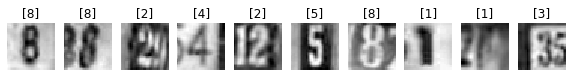

In [8]:
train_images = np.mean(train_images_rgb,axis=-1,keepdims=True)/255.
test_images = np.mean(test_images_rgb,axis=-1,keepdims=True)/255.
m = np.random.choice(N,10)
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].set_title(np.array2string(train_labels[m[i]]))
    ax[i].imshow(np.squeeze(train_images[m[i]]),cmap='gray')

มีอีกจุดหนึ่งที่ต้องแก้ไขสำหรับชุดข้อมูลนี้คือภาพที่แสดงเลข 0 จะมีเลเบลเป็น 10 เราจะเปลี่ยนเลเบลเป็น 0 

In [9]:
train_labels = np.where(train_labels==10,0,train_labels)
test_labels = np.where(test_labels==10,0,test_labels)

นำเข้าไลบรารีทั้งหมดที่ต้องการใช้ในการสร้างโมเดล DNN

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler 
from tensorflow.keras.optimizers import Adam

เราจะทดลองใช้โมเดลที่มีชั้นปกติ 4 ชั้น มีเซลล์ 128, 256, 128, 10 และคั่นแต่ละชั้นแฝงด้วยชั้นแบตช์นอร์ม 
แต่ละชั้นใช้ฟังก์ชันกระตุ้นแบบ ReLU ยกเว้นชั้นเอาต์พุตที่เป็นแบบ softmax
(ผู้อ่านสามารถทดลองปรับหรือเพิ่มชั้นในโมเดลตามใจชอบ)

In [11]:
model = Sequential([
    Flatten(input_shape=(32,32,1)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')    
])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               5

คอมไพล์โดยเลือกตัวหาค่าเหมาะที่สุดแบบ Adam อัตราการเรียนรู้ 0.001 

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

ในการฝึกเราจะใช้วิธีการลดระดับอัตราการเรียนรู้ตามสมการ (3.43) โดยกำหนด $decay\_rate = 1$ เขียนเป็นฟังก์ชัน scheduler() ได้ดังนี้

In [14]:
def scheduler(epoch, lr):
    return lr * (1/(1+epoch))

สร้างเป็นฟังก์ชันเรียกกลับ LearningRateScheduler() 

In [15]:
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

สำหรับฟังก์ชันเรียกกลับอีกตัวหนึ่งจะใช้เป็นแบบ EarlyStopping() เพื่อลดการฟิตเกิน

In [16]:
early_stopping = EarlyStopping(patience=3, monitor='val_accuracy', mode='max')

ใส่ค่าอาร์กิวเมนต์ของ model.fit() โดยเลืกจำนวนการฝึก 30 รอบ ขนาดกลุ่มเล็ก 256 แบ่งข้อมูล 15% สำหรับตรวจสอบ 
และกำหนดค่าฟังก์ชันเรียกกลับที่สร้างไว้

In [17]:
history=model.fit(train_images, train_labels, epochs=30, batch_size=256, validation_split = 0.15,
                  callbacks=[lr_scheduler,early_stopping])

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
244/244 [==============================] - 2s 5ms/step - loss: 1.2752 - accuracy: 0.5945 - val_loss: 1.5027 - val_accuracy: 0.5138
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005000000237487257.
244/244 [==============================] - 1s 4ms/step - loss: 0.7923 - accuracy: 0.7576 - val_loss: 1.1212 - val_accuracy: 0.6352
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.00016666667458290854.
244/244 [==============================] - 1s 4ms/step - loss: 0.6693 - accuracy: 0.7987 - val_loss: 0.8090 - val_accuracy: 0.7485
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 4.166666985838674e-05.
244/244 [==============================] - 1s 4ms/step - loss: 0.6211 - accuracy: 0.8133 - val_loss: 0.6745 - val_accuracy: 0.7954
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 8.333333971677348e-06.


จากเอาต์พุตจะเห็นว่าในแต่ละรอบค่าอัตราการเรียนรู้ลดลงตาม (3.43) และจะหยุดการฝึกเมื่อเงื่อนไขที่กำหนดใน EarlyStopping() เป็นจริง 
พล็อตค่าความแม่นยำและค่าสูญเสียได้ดังในรูปที่ 3.26

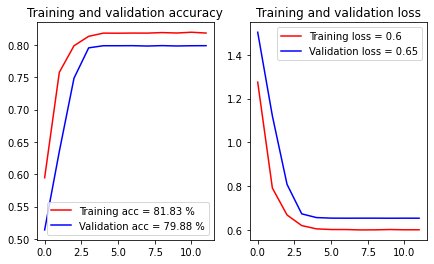

In [19]:
plot_acc_loss(history)

รูปที่ 3.26 ค่าความแม่นยำและค่าสูญเสียสำหรับตัวอย่าง 3.8 

เราสามารถประเมินความแม่นยำและค่าสูญเสียจากภาพที่ใช้ทดสอบโดยคำสั่ง model.evaluate() 

In [20]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.738
Test accuracy: 77.86%


รูปที่ 3.27 แสดงการสุ่มภาพจำนวน 5 ภาพจากชุดข้อมูลทดสอบ และดูผลการพยากรณ์จากโมเดลเปรียบเทียบกับเลเบลจริง 
กราฟแท่งทางด้านขวาแสดงค่าความน่าจะเป็นจากชั้นเอาต์พุตของโมเดล ซึ่งค่าสูงสุดคือตัวเลขที่โมเดลพยากรณ์
รันเซลล์ด้านล่างหลายครั้งเพื่อเปลี่ยนภาพ สังเกตภาพที่โมเดลพยากรณ์ไม่ถูกต้องว่ามีองค์ประกอบใดที่สร้างความสับสน 

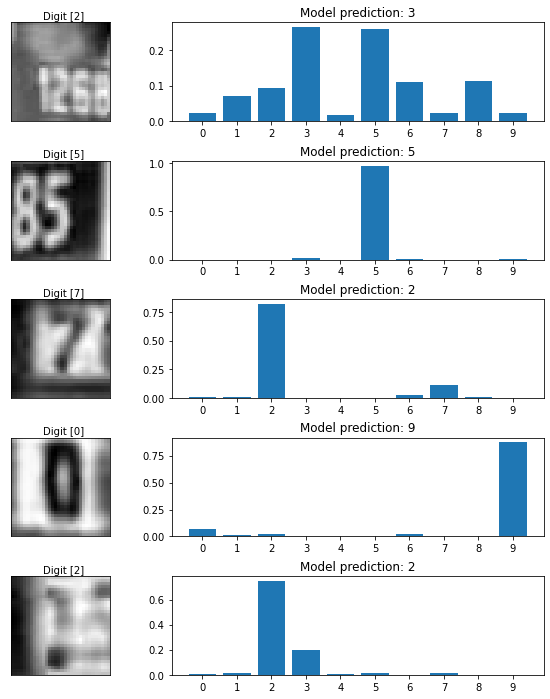

In [22]:
num_test_images = test_images.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

DNN_predictions = model.predict(random_test_images) 

fig, axes = plt.subplots(5, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(DNN_predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image),cmap='gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Model prediction: {np.argmax(prediction)}")

plt.show()

รูปที่ 3.27 ผลการพยากรณ์ภาพโดยโมเดล DNN

## 3.6 สรุปท้ายบท

เนื้อหาในบทนี้กล่าวถึงการปรับปรุงโมเดล DNN เพื่อเพิ่มประสิทธิภาพการเรียนรู้ โดยประกอบด้วยหลายส่วนตั้งแต่การจัดรูปข้อมูลเพื่อช่วยให้การฝึกง่ายและเร็วขึ้น 
การลดการฟิตเกินโดยทำเรกูลาร์ไรเซชันแบบต่างๆ วิธีดรอปเอาต์ และการหยุดฝึกตามเงื่อนไขที่กำหนด 
การกำหนดค่าเริ่มต้นของพารามิเตอร์สามารถช่วยให้ขั้นตอนวิธีลดค่าเกรเดียนต์ทำงานเร็วขึ้นโดยไม่ทำให้เกรเดียนต์มีค่ามากหรือน้อยเกินไป 

จากขั้นตอนวิธีลดค่าเกรเดียนต์ขั้นพื้นฐานได้มีการปรับปรุงสมรรถนะโดยเพิ่มพจน์ที่ช่วยลดทอนการแกว่งของความชันพารามิเตอร์ โดยทั่วไปวิธีการโมเมนตัม 
RMSprop หรือ Adam จะให้ผลดีกว่า SGD ดังนั้นจึงเป็นที่นิยมในการฝึกโมเดล โดยอาจใช้ร่วมกับวิธีการลดระดับอัตราการเรียนรู้ตามจำนวนรอบการฝึก 

การเพิ่มชั้นแบตช์นอร์มเป็นอีกวิธีหนึ่งในการปรับปรุงโมเดล โดยหลักการคือทำให้ค่าเฉลี่ยและความแปรปรวนของเอาต์พุตของชั้นแฝงเป็นพารามิเตอร์ที่เรียนรู้ได้ 
ทำให้มีค่าเหมาะสมสำหรับฟังก์ชันกระตุ้นในชั้นแฝงนั้น 

ถึงแม้ว่าโดยภาพรวมแล้วโมเดล DNN จะประกอบด้วยไฮเปอร์พารามิเตอร์หลายตัว แต่จะพบว่าบางตัวไม่มีผลกระทบเด่นชัดกับสมรรถนะการเรียนรู้ 
ตัวอย่างเช่นค่า $\epsilon$ ที่ใส่ไว้เพื่อป้องกันการหารด้วยค่าศูนย์จะไม่เห็นความแตกต่างระหว่างค่า $10^{-6}, 10^{-7}, 10^{-8}$ 
ดังนั้นจึงไม่ควรเสียเวลาเพื่อแปรค่าไฮเปอร์พารามิเตอร์ตัวนี้ แตกต่างจากอัตราการเรียนรู้ $\alpha$ ซึ่งอาจต้องใช้เวลาในการปรับแต่งเพื่อให้ได้ผลดี

การปรับแต่งค่าไฮเปอร์พารามิเตอร์เป็นเพียงการทำให้โมเดลมีคุณภาพดีที่สุดเท่าที่จะทำได้สำหรับสถาปัตยกรรมโครงข่ายประสาทเทียมที่ใช้อยู่ 
หากพบว่าความแม่นยำยังไม่เป็นที่พอใจอาจต้องพิจารณาสถาปัตยกรรมอื่นที่เหมาะสมสำหรับโจทย์ปัญหานั้น ตัวอย่างเช่นในการจำแนกภาพโดยทั่วไป 
เรามักจะพบว่าการปรับแต่งไฮเปอร์พารามิเตอร์ไม่สามารถช่วยให้โมเดล DNN มีความแม่นยำสูงเกิน 90% ได้ 
ในบทต่อไปจะกล่าวถึงสถาปัตยกรรมที่เหมาะสมกว่าสำหรับงานจำแนกภาพ


## โจทย์ปัญหา

3-1 จากชุดข้อมูลที่มีให้ในไลบรารี sklearn ดังโจทย์ปัญหาข้อ 2-4 เขียนโค้ดไพธอนเพื่อสุ่มแยกข้อมูลเป็นชุดฝึกและชุดทดสอบตามอัตราส่วนที่กำหนด 
เช่น 80%, 20 % 

3-2 ในการฝึกโมเดลโดยไลบรารี TF เราสามารถกันข้อมูลส่วนหนึ่งเป็นชุดสำหรับตรวจสอบได้โดยใช้อาร์กิวเมนต์ 
validation_split ในเมธอด model.fit() เช่น validation_split=0.2 จะแยกข้อมูล 20% จากข้อมูลทั้งหมดสำหรับใช้ตรวจสอบ 
สร้างโมเดลเพื่อฝึกโดยใช้ข้อมูลจากโจทย์ข้อ 3-1 เปรียบเทียบระหว่างโมเดลเส้นฐาน การทำเรกูลาร์ไรเซชัน และดรอปเอาต์

3-3 จากตัวอย่าง 3.5 ทดลองฝึกโมเดลด้วยจำนวนรอบที่มากขึ้น ผลการจำแนกมีความแม่นยำมากขึ้นหรือไม่ อธิบาย

3-4 จากตัวอย่าง 3.5 ตั้งค่าเริ่มต้นของค่าน้ำหนัก $W \in [a,b]$ โดยทดลองแปรค่าต่ำสุดและสูงสุด (อาจเลือกเป็นค่าลบได้โดย $a<b$) เพื่อดูผลที่เกิดขึ้น 
ท่านสามารถหาค่าของ $a, b$ ที่ให้ผลการพยากรณ์เป็นที่น่าพอใจได้หรือไม่

3-5 มีการนำเสนอการตั้งค่าเริ่มต้นเพื่อกำหนดความแปรปรวนของ $W^{[l]}$ ในรูปแบบอื่นเช่น $\frac{2}{n^{[l-1]}+n^{[l]}}$ 
สามารถทดลองใช้โดยตั้งค่า initializer เป็นแบบ GlorotNormal ทดลองใช้เพื่อเปรียบเทียบผลกับตัวอย่าง 3.6 

3-6 ในการใช้ไลบรารี TF สามารถเปิดใช้วิธีโมเมนตัมในตัวหาค่าเหมาะที่สุดแบบ SGD() โดยกำหนดค่า momentum 
ให้มีค่ามากกว่าศูนย์ โดยการปรับค่าพารามิเตอร์ $w$ สำหรับเกรเดียนต์ $g$ จะเป็นดังนี้

velocity = momentum*velocity - learning_rate*g
w = w + velocity

* เชื่อมโยงความสัมพันธ์ของโค้ดนี้กับเค้าโครงที่นำเสนอในหัวข้อย่อย 3.4.2 
* ทดลองใช้โมเมนตัมกับข้อมูลในตัวอย่าง 3.6 เปรียบเทียบข้อมูลจากการฝึกเพื่อตรวจสอบว่าตัวหาค่าเหมาะที่สุดทำงานเร็วขึ้นหรือไม่

3-7 วิธีการโมเมนตัมที่ถูกขยายเป็นขั้นสูงขึ้นเรียกว่า nesterov ซึ่งเลือกใช้ได้ในไลบรารี TF การเปิดใช้งานทำได้โดยตั้งค่า nesterov=True 
เป็นอาร์กิวเมนต์ของ SGD() กฏการปรับค่าเป็นดังนี้

velocity = momentum * velocity - learning_rate * g
w = w + momentum * velocity - learning_rate * g

ทดลองใช้วิธี nesterov กับข้อมูลในตัวอย่าง 3.6

3-8 จากตัวอย่าง 3.7 เลือกตัวหาค่าเหมาะที่สุดวิธีที่ท่านชอบ เขียนฟังก์ชันเรียกกลับเพื่อปรับค่าอัตราการเรียนรู้ให้ลดลงโดยใช้ไลบรารี
tf.keras.callbacks.LearningRateScheduler()

3-9 ทดลองปรับเปลี่ยนหรือเพิ่มเติมชั้นและไฮเปอร์พารามิเตอร์ของโมเดลในตัวอย่าง 3.8 ค่าความแม่นยำที่ดีที่สุดที่ท่านทำได้คือเท่าไร




<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>